In [1]:
%load_ext autoreload
%autoreload 2

DALL-E's original notebook has a problem

In [6]:
from pathlib import Path
import torch

# save them locally from -
# enc_url = "https://cdn.openai.com/dall-e/encoder.pkl"
# dec_url = "https://cdn.openai.com/dall-e/decoder.pkl"
model_ckpts_dir = Path("model_ckpts")
enc_path = (model_ckpts_dir / "enc.pt").resolve()

enc = torch.load(enc_path)




In [13]:
"""Signature is

def convert_dalle_checkpoint(
    checkpoint_path,
    pytorch_dump_folder_path,
    config_path=None,
    save_checkpoint=True
)
checkpoint_path is the path to the pkl file from dalle
"""

from transformers.models.flava.convert_dalle_to_flava_codebook import (
    convert_dalle_checkpoint,
)
from transformers import FlavaImageCodebook, FlavaImageCodebookConfig


state_dict = convert_dalle_checkpoint(str(enc_path), None, save_checkpoint=False)
config = FlavaImageCodebookConfig()
hf_model = FlavaImageCodebook(config).eval()
hf_model.load_state_dict(state_dict)


The below is from https://github.com/openai/DALL-E/blob/master/notebooks/usage.ipynb to set up Image -> torch.Tensor conversion

/opt/homebrew/Caskroom/mambaforge/base/envs/py-310/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


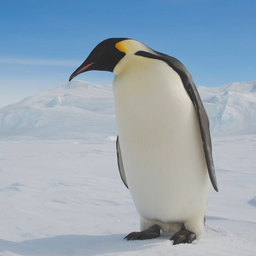

In [16]:
import io
import PIL
import requests
from dall_e import map_pixels
import torchvision.transforms as T
import torchvision.transforms.functional as TF

target_image_size = 256
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display(T.ToPILImage(mode='RGB')(x[0]))

You can see that the DALL-E encoder is the same as the `hf_model.get_code_book_indices` o

In [19]:
import numpy as np

# from https://github.com/openai/DALL-E/blob/master/notebooks/usage.ipynb cell
dall_e_out_logits = enc(x)
dall_e_out = torch.argmax(dall_e_out_logits, axis=1)

# equivalent to the above! 
flava_out = hf_model.get_codebook_indices(x)

# verify they're the same
np.allclose(dall_e_out.detach().numpy(), flava_out.detach().detach())

# continue decoding...


True